<a href="https://colab.research.google.com/github/lukechang93-ucla/MAE-263F/blob/main/homework_5/Homework5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Discrete Elastic Shells: Simple Example with Four Nodes
Copyright M. Khalid Jawed (khalidjm@seas.ucla.edu). License: CC BY-NC
You should use this code at your own risk.

Modifications to MAE_263F in class example by Professor M. Khalid Jawed.


#Load Libraries

In [637]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

#Miscellaneous Functions: signedAngle, rotateAxisAngle, parallel_transport, crossMat

In [638]:
def signedAngle(u = None,v = None,n = None):
    # This function calculates the signed angle between two vectors, "u" and "v",
    # using an optional axis vector "n" to determine the direction of the angle.
    #
    # Parameters:
    #   u: numpy array-like, shape (3,), the first vector.
    #   v: numpy array-like, shape (3,), the second vector.
    #   n: numpy array-like, shape (3,), the axis vector that defines the plane
    #      in which the angle is measured. It determines the sign of the angle.
    #
    # Returns:
    #   angle: float, the signed angle (in radians) from vector "u" to vector "v".
    #          The angle is positive if the rotation from "u" to "v" follows
    #          the right-hand rule with respect to the axis "n", and negative otherwise.
    #
    # The function works by:
    # 1. Computing the cross product "w" of "u" and "v" to find the vector orthogonal
    #    to both "u" and "v".
    # 2. Calculating the angle between "u" and "v" using the arctan2 function, which
    #    returns the angle based on the norm of "w" (magnitude of the cross product)
    #    and the dot product of "u" and "v".
    # 3. Using the dot product of "n" and "w" to determine the sign of the angle.
    #    If this dot product is negative, the angle is adjusted to be negative.
    #
    # Example:
    #   signedAngle(np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]))
    #   This would return a positive angle (π/2 radians), as the rotation
    #   from the x-axis to the y-axis is counterclockwise when viewed along the z-axis.
    w = np.cross(u,v)
    angle = np.arctan2( np.linalg.norm(w), np.dot(u,v) )
    if (np.dot(n,w) < 0):
        angle = - angle

    return angle

In [639]:
def mmt(matrix):
    return matrix + matrix.T

# Hinge angle, its gradient, and Hessian

In [640]:
#          x2
#          /\
#         /  \
#      e1/    \e3
#       /  t0  \
#      /        \
#     /    e0    \
#   x0------------x1
#     \          /
#      \   t1   /
#       \      /
#      e2\    /e4
#         \  /
#          \/
#          x3
#
#  Edge orientation: e0,e1,e2 point away from x0
#                       e3,e4 point away from x1

In [641]:
def getTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0

    n0 = np.cross(m_e0, m_e1)
    n1 = np.cross(m_e2, m_e0)

    # Calculate the signed angle using the provided function
    theta = signedAngle(n0, n1, m_e0)

    return theta

In [642]:
# In the original code, there are probaly TWO sign errors in the expressions for m_h3 and m_h4.
# [Original code: % https://github.com/shift09/plates-shells/blob/master/src/bending.cpp]
# I indicated those two corrections by writing the word "CORRECTION" next
# to them.

def gradTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0
    m_e3 = x2 - x1
    m_e4 = x3 - x1

    m_cosA1 = np.dot(m_e0, m_e1) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_cosA2 = np.dot(m_e0, m_e2) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_cosA3 = -np.dot(m_e0, m_e3) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_cosA4 = -np.dot(m_e0, m_e4) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_sinA1 = np.linalg.norm(np.cross(m_e0, m_e1)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_sinA2 = np.linalg.norm(np.cross(m_e0, m_e2)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_sinA3 = -np.linalg.norm(np.cross(m_e0, m_e3)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_sinA4 = -np.linalg.norm(np.cross(m_e0, m_e4)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_nn1 = np.cross(m_e0, m_e3)
    m_nn1 = m_nn1 / np.linalg.norm(m_nn1)
    m_nn2 = -np.cross(m_e0, m_e4)
    m_nn2 = m_nn2 / np.linalg.norm(m_nn2)

    m_h1 = np.linalg.norm(m_e0) * m_sinA1
    m_h2 = np.linalg.norm(m_e0) * m_sinA2
    m_h3 = -np.linalg.norm(m_e0) * m_sinA3  # CORRECTION
    m_h4 = -np.linalg.norm(m_e0) * m_sinA4  # CORRECTION
    m_h01 = np.linalg.norm(m_e1) * m_sinA1
    m_h02 = np.linalg.norm(m_e2) * m_sinA2

    # Initialize the gradient
    gradTheta = np.zeros(12)

    gradTheta[0:3] = m_cosA3 * m_nn1 / m_h3 + m_cosA4 * m_nn2 / m_h4
    gradTheta[3:6] = m_cosA1 * m_nn1 / m_h1 + m_cosA2 * m_nn2 / m_h2
    gradTheta[6:9] = -m_nn1 / m_h01
    gradTheta[9:12] = -m_nn2 / m_h02

    return gradTheta

In [643]:
def hessTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0
    m_e3 = x2 - x1
    m_e4 = x3 - x1

    m_cosA1 = np.dot(m_e0, m_e1) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_cosA2 = np.dot(m_e0, m_e2) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_cosA3 = -np.dot(m_e0, m_e3) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_cosA4 = -np.dot(m_e0, m_e4) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_sinA1 = np.linalg.norm(np.cross(m_e0, m_e1)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_sinA2 = np.linalg.norm(np.cross(m_e0, m_e2)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_sinA3 = -np.linalg.norm(np.cross(m_e0, m_e3)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_sinA4 = -np.linalg.norm(np.cross(m_e0, m_e4)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_nn1 = np.cross(m_e0, m_e3)
    m_nn1 /= np.linalg.norm(m_nn1)
    m_nn2 = -np.cross(m_e0, m_e4)
    m_nn2 /= np.linalg.norm(m_nn2)

    m_h1 = np.linalg.norm(m_e0) * m_sinA1
    m_h2 = np.linalg.norm(m_e0) * m_sinA2
    m_h3 = -np.linalg.norm(m_e0) * m_sinA3
    m_h4 = -np.linalg.norm(m_e0) * m_sinA4
    m_h01 = np.linalg.norm(m_e1) * m_sinA1
    m_h02 = np.linalg.norm(m_e2) * m_sinA2

    # Gradient of Theta (as an intermediate step)
    grad_theta = np.zeros((12, 1))
    grad_theta[0:3] = (m_cosA3 * m_nn1 / m_h3 + m_cosA4 * m_nn2 / m_h4).reshape(-1, 1)
    grad_theta[3:6] = (m_cosA1 * m_nn1 / m_h1 + m_cosA2 * m_nn2 / m_h2).reshape(-1, 1)
    grad_theta[6:9] = (-m_nn1 / m_h01).reshape(-1, 1)
    grad_theta[9:12] = (-m_nn2 / m_h02).reshape(-1, 1)

    # Intermediate matrices for Hessian
    m_m1 = np.cross(m_nn1, m_e1) / np.linalg.norm(m_e1)
    m_m2 = -np.cross(m_nn2, m_e2) / np.linalg.norm(m_e2)
    m_m3 = -np.cross(m_nn1, m_e3) / np.linalg.norm(m_e3)
    m_m4 = np.cross(m_nn2, m_e4) / np.linalg.norm(m_e4)
    m_m01 = -np.cross(m_nn1, m_e0) / np.linalg.norm(m_e0)
    m_m02 = np.cross(m_nn2, m_e0) / np.linalg.norm(m_e0)

    # Hessian matrix components
    M331 = m_cosA3 / (m_h3 ** 2) * np.outer(m_m3, m_nn1)
    M311 = m_cosA3 / (m_h3 * m_h1) * np.outer(m_m1, m_nn1)
    M131 = m_cosA1 / (m_h1 * m_h3) * np.outer(m_m3, m_nn1)
    M3011 = m_cosA3 / (m_h3 * m_h01) * np.outer(m_m01, m_nn1)
    M111 = m_cosA1 / (m_h1 ** 2) * np.outer(m_m1, m_nn1)
    M1011 = m_cosA1 / (m_h1 * m_h01) * np.outer(m_m01, m_nn1)

    M442 = m_cosA4 / (m_h4 ** 2) * np.outer(m_m4, m_nn2)
    M422 = m_cosA4 / (m_h4 * m_h2) * np.outer(m_m2, m_nn2)
    M242 = m_cosA2 / (m_h2 * m_h4) * np.outer(m_m4, m_nn2)
    M4022 = m_cosA4 / (m_h4 * m_h02) * np.outer(m_m02, m_nn2)
    M222 = m_cosA2 / (m_h2 ** 2) * np.outer(m_m2, m_nn2)
    M2022 = m_cosA2 / (m_h2 * m_h02) * np.outer(m_m02, m_nn2)

    B1 = 1 / np.linalg.norm(m_e0) ** 2 * np.outer(m_nn1, m_m01)
    B2 = 1 / np.linalg.norm(m_e0) ** 2 * np.outer(m_nn2, m_m02)

    N13 = 1 / (m_h01 * m_h3) * np.outer(m_nn1, m_m3)
    N24 = 1 / (m_h02 * m_h4) * np.outer(m_nn2, m_m4)
    N11 = 1 / (m_h01 * m_h1) * np.outer(m_nn1, m_m1)
    N22 = 1 / (m_h02 * m_h2) * np.outer(m_nn2, m_m2)
    N101 = 1 / (m_h01 ** 2) * np.outer(m_nn1, m_m01)
    N202 = 1 / (m_h02 ** 2) * np.outer(m_nn2, m_m02)

    # Initialize Hessian of Theta
    hess_theta = np.zeros((12, 12))

    hess_theta[0:3, 0:3] = mmt(M331) - B1 + mmt(M442) - B2
    hess_theta[0:3, 3:6] = M311 + M131.T + B1 + M422 + M242.T + B2
    hess_theta[0:3, 6:9] = M3011 - N13
    hess_theta[0:3, 9:12] = M4022 - N24
    hess_theta[3:6, 3:6] = mmt(M111) - B1 + mmt(M222) - B2
    hess_theta[3:6, 6:9] = M1011 - N11
    hess_theta[3:6, 9:12] = M2022 - N22
    hess_theta[6:9, 6:9] = -mmt(N101)
    hess_theta[9:12, 9:12] = -mmt(N202)

    # Make the Hessian symmetric
    hess_theta[3:6, 0:3] = hess_theta[0:3, 3:6].T
    hess_theta[6:9, 0:3] = hess_theta[0:3, 6:9].T
    hess_theta[9:12, 0:3] = hess_theta[0:3, 9:12].T
    hess_theta[6:9, 3:6] = hess_theta[3:6, 6:9].T
    hess_theta[9:12, 3:6] = hess_theta[3:6, 9:12].T

    return hess_theta


# Stretching energy for a shell, it's gradient, and Hessian

In [644]:
def gradEs_hessEs(node0 = None,node1 = None,l_k = None,EA = None):

# Inputs:
# node0: 1x3 vector - position of the first node
# node1: 1x3 vector - position of the last node

# l_k: reference length (undeformed) of the edge
# EA: scalar - stretching stiffness - Young's modulus times area

# Outputs:
# dF: 6x1  vector - gradient of the stretching energy between node0 and node 1.
# dJ: 6x6 vector - hessian of the stretching energy between node0 and node 1.

    ## Gradient of Es
    edge = node1 - node0

    edgeLen = np.linalg.norm(edge)
    tangent = edge / edgeLen
    epsX = edgeLen / l_k - 1
    dF_unit = EA * tangent * epsX
    dF = np.zeros((6))
    dF[0:3] = - dF_unit
    dF[3:6] = dF_unit

    ## Hessian of Es
    Id3 = np.eye(3)
    M = EA * ((1 / l_k - 1 / edgeLen) * Id3 + 1 / edgeLen * ( np.outer( edge, edge ) ) / edgeLen ** 2)

    dJ = np.zeros((6,6))
    dJ[0:3,0:3] = M
    dJ[3:6,3:6] = M
    dJ[0:3,3:6] = - M
    dJ[3:6,0:3] = - M
    return dF,dJ

# Bending energy for a shell, it's gradient, and Hessian

In [645]:
def getEb_Shell(x0, x1=None, x2=None, x3=None, theta_bar=0, kb=1.0):
    """
    Compute the bending energy for a shell.

    Returns:
    E (scalar): Bending energy.
    """
    # Allow another type of input where x0 contains all the information
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[:3]

    # Compute theta, gradient, and Hessian
    theta = getTheta(x0, x1, x2, x3)  # Replace with your getTheta function in Python
    grad = gradTheta(x0, x1, x2, x3)  # Replace with your gradTheta function in Python

    # E = 0.5 * kb * (theta-thetaBar)^2
    E = 0.5 * kb * (theta - theta_bar) ** 2

    return E

In [646]:
def gradEb_hessEb_Shell(x0, x1=None, x2=None, x3=None, theta_bar=0, kb=1.0):
    """
    Compute the gradient and Hessian of the bending energy for a shell.

    Parameters:
    x0 (array): Can either be a 3-element array (single point) or a 12-element array.
    x1, x2, x3 (arrays): Optional, 3-element arrays specifying points.
    theta_bar (float): Reference angle.
    kb (float): Bending stiffness.

    Returns:
    dF (array): Gradient of the bending energy.
    dJ (array): Hessian of the bending energy.
    """
    # Allow another type of input where x0 contains all the information
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[:3]

    # Compute theta, gradient, and Hessian
    theta = getTheta(x0, x1, x2, x3)  # Replace with your getTheta function in Python
    grad = gradTheta(x0, x1, x2, x3)  # Replace with your gradTheta function in Python

    # E = 0.5 * kb * (theta-thetaBar)^2
    # F = dE/dx = 2 * (theta-thetaBar) * gradTheta
    dF = 0.5 * kb * (2 * (theta - theta_bar) * grad)

    # E = 0.5 * kb * (theta-thetaBar)^2
    # F = 0.5 * kb * (2 (theta-thetaBar) d theta/dx)
    # J = dF/dx = 0.5 * kb * [ 2 (d theta / dx) transpose(d theta/dx) +
    #       2 (theta-thetaBar) (d^2 theta/ dx^2 ) ]
    hess = hessTheta(x0, x1, x2, x3)  # Replace with your hessTheta function in Python
    dJ = 0.5 * kb * (2 * np.outer(grad, grad) + 2 * (theta - theta_bar) * hess)

    return dF, dJ

#Plot the shell

In [647]:
# Function to set equal aspect ratio for 3D plots
def set_axes_equal(ax):
    """
    Set equal aspect ratio for a 3D plot in Matplotlib.
    This function adjusts the limits of the plot to make sure
    that the scale is equal along all three axes.
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])

In [648]:
def plotShell(x0, ctime):
  x0 = x0.reshape((x0.size//3, 3))

  fig = plt.figure(1)
  clear_output()
  plt.clf()  # Clear the figure
  ax = fig.add_subplot(111, projection='3d')

  X, Y, Z = [], [], []
  # 0-9, 19-10 bottom nodes, then top nodes
  for i in range(half):
    X.append(x0[i,0])
    Y.append(x0[i,1])
    Z.append(x0[i,2])
  for i in range(half):
    X.append(x0[nv-1-i,0])
    Y.append(x0[nv-1-i,1])
    Z.append(x0[nv-1-i,2])
  # 0,1,11,12,2,3,13,...8,9 zig zag for vertical edge connections
  for i in range(0,half-1,2):
    X.extend([x0[i,0],x0[i+1,0]])
    Y.extend([x0[i,1],x0[i+1,1]])
    Z.extend([x0[i,2],x0[i+1,2]])
    if i < half-2:
      X.extend([x0[i+1+half,0],x0[i+2+half,0]])
      Y.extend([x0[i+1+half,1],x0[i+2+half,1]])
      Z.extend([x0[i+1+half,2],x0[i+2+half,2]])
  # 9-18,18-7,7-16,...,1-10 zig zag backwards for slanted connections
  diag = [half-1, nv-2, half-3, nv-4, half-5, nv-6, half-7, nv-8, half-9, half]
  for a, b in zip(diag[:-1], diag[1:]):
    X.extend([x0[a,0], x0[b,0]])
    Y.extend([x0[a,1], x0[b,1]])
    Z.extend([x0[a,2], x0[b,2]])

  ax.plot3D(X, Y, Z, 'ko-')

  # Plot the first node with a red triangle
  ax.plot3D([X[0]], [Y[0]], [Z[0]], 'r^')

  # Set the title with current time
  ax.set_title(f't={ctime:.2f}')

  # Set axes labels
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')

  # Set equal scaling and a 3D view
  set_axes_equal(ax)
  plt.draw()  # Force a redraw of the figure

  plt.show()

# Objective function

In [649]:
def objfun(qOld, uOld, freeIndex, dt, tol, massVector, massMatrix,
           ks, refLen, edges,
           kb, thetaBar, hinges,
           Fg, visc):

  qNew = qOld.copy()
  ndof = len(qOld) # Number of DOFs

  iter = 0 # number of iteration
  error = 10 * tol
  # Newton Raphson
  while error > tol:

    # Bending force and jacobian
    Fb = np.zeros( ndof )
    Jb = np.zeros( (ndof,ndof) )
    # Loop over every "bending spring" or "hinge"
    for kHinge in range(hinges.shape[0]):
      node0 = hinges[kHinge, 0]
      node1 = hinges[kHinge, 1]
      node2 = hinges[kHinge, 2]
      node3 = hinges[kHinge, 3]
      x0 = qNew[ 3*node0: 3*node0 + 3]
      x1 = qNew[ 3*node1: 3*node1 + 3]
      x2 = qNew[ 3*node2: 3*node2 + 3]
      x3 = qNew[ 3*node3: 3*node3 + 3]
      ind = [3*node0, 3*node0 + 1, 3*node0 + 2,
             3*node1, 3*node1 + 1, 3*node1 + 2,
             3*node2, 3*node2 + 1, 3*node2 + 2,
             3*node3, 3*node3 + 1, 3*node3 + 2]
      dF, dJ = gradEb_hessEb_Shell(x0, x1, x2, x3, thetaBar, kb)
      Fb[ind] -= dF
      Jb[np.ix_(ind,ind)] -= dJ

    # Stretching force and jacobian
    Fs = np.zeros( ndof )
    Js = np.zeros( (ndof,ndof) )
    for kEdge in range(edges.shape[0]):
      node0 = edges[kEdge, 0]
      node1 = edges[kEdge, 1]
      x0 = qNew[ 3*node0: 3*node0 + 3]
      x1 = qNew[ 3*node1: 3*node1 + 3]
      ind = [3*node0, 3*node0 + 1, 3*node0 + 2,
             3*node1, 3*node1 + 1, 3*node1 + 2]
      dF, dJ = gradEs_hessEs(x0, x1, refLen[kEdge], ks[kEdge])
      Fs[ind] -= dF
      Js[np.ix_(ind,ind)] -= dJ

    # Viscous force
    Fv = - visc * (qNew - qOld) / dt
    Jv = - visc / dt * np.eye(ndof)

    Forces = Fb + Fs + Fg + Fv # Sum of forces
    JForces = Jb + Js + Jv # Sum of Jacobians

    # Set up my equations of motion and calculating its residual (=0)
    f = massVector / dt * ( (qNew - qOld)/dt - uOld) - Forces # Residual of EOM
    J = massMatrix / dt ** 2 - JForces

    # Extract the free part of the f and J arrays
    f_free = f[freeIndex]
    J_free = J[np.ix_(freeIndex, freeIndex)]
    # Correction
    dq_free = np.linalg.solve(J_free, f_free)

    # Update my guess for position
    qNew[freeIndex] -= dq_free

    # Calculate error
    error = np.sum( np.abs(f_free))

    iter += 1

    print('Iter = ', iter, ' error=', error)

  uNew = (qNew - qOld) / dt
  return qNew, uNew

#Main Discrete Shells

**DOFs and Nodes**

In [650]:
#GIVENS
l = 0.1 #m
w = 0.01 #m
h = 0.002 #m Thickness

Y = 1.0e7 #Pa
rho = 1000 #kg/m^3

A = w*h #m^2
I = w*h**3/12 #m^4  Second moment of Area

g = 9.8 #m/s^2
q = rho*A*g # Distributed load from gravity kgm/s^2 per m

nv = 20
half = int(nv/2)

lstep = .0125


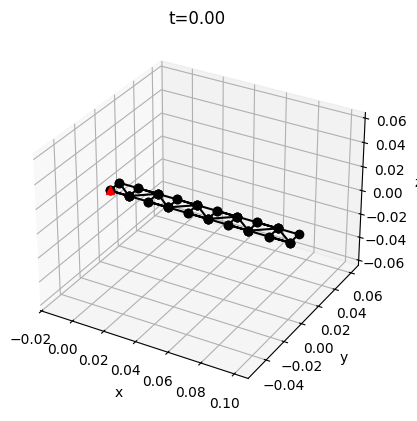

In [651]:
x = np.zeros((nv,3))
z = 0

for i in range(nv):
  if i < nv/2: x[i] = np.array([-lstep + lstep*i, 0, z])
  else: x[i] = np.array([-lstep + lstep*(i-10), w, z])

qOld = np.concatenate(x)
plotShell(qOld, 0)

nv = nv
ndof = 3 * nv
visc = 0 # May need for convergence

**Springs: Create edges (stretching) and hinges (bending)**

In [652]:
# edges = np.array( [ (0,1), (0,2), (0,3), (1,2), (1,3)  ] )
# hinges = np.array( [ (0,1, 2, 3)  ] )

edges, hinges = [], []
slants = []
for i in range(half//2):
  slants.append(half+2*i)
  slants.append(1+2*i)

#edges construction
for i in range(half-1): #horizontals
  edges.append((i,i+1))
  edges.append((half+i,half+1+i))
for i in range(half): #verticals
  edges.append((i,half+i))
for a, b in zip(slants[:-1], slants[1:]): #slants
    edges.append((a, b))

#hinges construction
# 1,10,0,11; 1,11,10,12; 12,1,11,2; 12,2,1,3; 3,12,2,13; 3,13,12,14; ...;18,7,17,8; 18,8,7,9
for i in range((half-2)//2):
    b = 1+2*i #bottom starts
    tL = (half-1)+b
    tR = tL+1
    hinges.append((b, tL, b-1, tR))
    hinges.append((b, tR, tL, tR+1))

    t = half+2+2*i #top starts
    bL = t-(half+1)
    bR = bL+1
    tL2 = t-1
    tR2 = t+1
    hinges.append((t, bL, tL2, bR))
    hinges.append((t, bR, bL, bR+1))

    if i == (half-2)//2 - 1: #would need edit for odd # of top/bottom nodes
      b = 3+2*i #last bottom start
      tL = (half-1)+b
      tR = tL+1
      hinges.append((b, tL, b-1, tR))

edges = np.array(edges)
hinges = np.array(hinges)


**Elastic Stiffness**

In [653]:
Y = Y # Young's modulus in Pa
h = h # Thickness in meter

# Stiffness variables
kb = 2.0 / np.sqrt(3.0) * Y * h**3.0 / 12 # Bending stiffness (Newton-meter)
refLen = np.zeros(edges.shape[0]) # reference length, denoted as l_k
ks = np.zeros_like(refLen) # Stretching stiffness
for kEdge in range(edges.shape[0]):
  node0 = edges[kEdge, 0]
  node1 = edges[kEdge, 1]
  x0 = qOld[ 3*node0: 3*node0 + 3]
  x1 = qOld[ 3*node1: 3*node1 + 3]
  refLen[kEdge] = np.linalg.norm(x1 - x0)
  ks[kEdge] = np.sqrt(3.0) / 2.0 * Y * h * (refLen[kEdge]) ** 2

**Time parameters**

In [654]:
totalTime = 5 # seconds
dt = 0.005 # time step sie

tol = kb / (0.01) * 1e-3 # Approximate tolerance

**Mass Vector and Matrix**

In [655]:
# rho = 1000 # Density
totalM = rho*A*l # total mass in kg
dm = totalM / nv # mass per nodes -- approximation
massVector = np.zeros(ndof)
for c in range(nv): # Loop over every node
  ind = [3*c, 3*c+1, 3*c+2] # location of the c-th node in the DOF vector
  massVector[ind] = dm
massMatrix = np.diag(massVector)

**External force**

In [656]:
g = np.array([0, 0, -9.8])
Fg = np.zeros(ndof)
for c in range(nv):
  ind = [3*c, 3*c+1, 3*c+2]
  Fg[ind] = massVector[ind] * g

**Natural curvature**

In [657]:
thetaBar = 0 #getTheta(qOld)

**Boundary conditions and Initial Conditions**

In [658]:
# qOld is already computed
uOld = np.zeros(ndof) # Initialize velocity

all_DOFs = np.arange(ndof)
fixedIndex = np.array([0,1,2, 3,4,5, 30,31,32, 33,34,35])
freeIndex = np.setdiff1d(all_DOFs, fixedIndex)

**Time stepping loop**

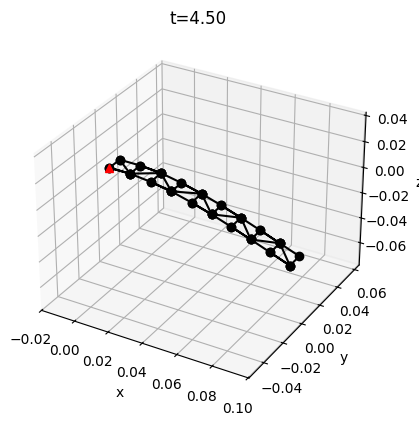

Current time =4.505000
Iter =  1  error= 0.0005762358912490579
Current time =4.510000
Iter =  1  error= 0.0006902366325936844
Current time =4.515000
Iter =  1  error= 0.0007959452406401988
Iter =  2  error= 1.319365546305301e-06
Current time =4.520000
Iter =  1  error= 0.0008923231889854325
Iter =  2  error= 1.6585889573896158e-06
Current time =4.525000
Iter =  1  error= 0.0009785758034218026
Iter =  2  error= 1.9948795521715637e-06
Current time =4.530000
Iter =  1  error= 0.0010538557142214925
Iter =  2  error= 2.3138337377561273e-06
Current time =4.535000
Iter =  1  error= 0.0011174906858225193
Iter =  2  error= 2.602093419942285e-06
Current time =4.540000
Iter =  1  error= 0.0011689603531227434
Iter =  2  error= 2.8478149262005107e-06
Current time =4.545000
Iter =  1  error= 0.0012078740715033192
Iter =  2  error= 3.04111879725424e-06
Current time =4.550000
Iter =  1  error= 0.0012339689008236125
Iter =  2  error= 3.174477126089413e-06
Current time =4.555000
Iter =  1  error= 0.0012

In [659]:
Nsteps = round(totalTime / dt) # Number of time steps
ctime = 0 # Current time
endZ = np.zeros(Nsteps) # z-coordinate of the last node

for timeStep in range(Nsteps):
  print('Current time =%f' % ctime)

  qNew, uNew = objfun(qOld, uOld, freeIndex, dt, tol, massVector, massMatrix, ks, refLen, edges, kb, thetaBar, hinges, Fg, visc)
  ctime += dt

  # Update my old positions and velocities
  qOld = qNew.copy()
  uOld = uNew.copy()

  # Store endZ
  endZ[timeStep] = qNew[-1]

  # Plot the shell
  if timeStep % 100 == 0:
    plotShell(qOld, ctime)

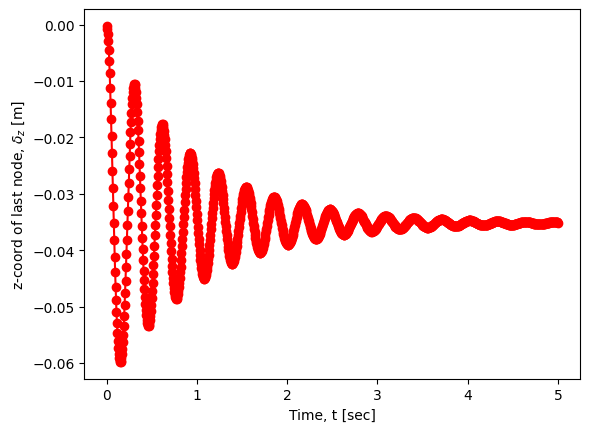

In [660]:
# # Visualize
# plt.figure(2)
# time_array = np.arange(1, Nsteps+1) * dt
# plt.plot(time_array, endZ, 'ro-')
# plt.box(True)
# plt.xlabel('Time, t [sec]')
# plt.ylabel('z-coord of last node, $\\delta_z$ [m]')
# plt.show()

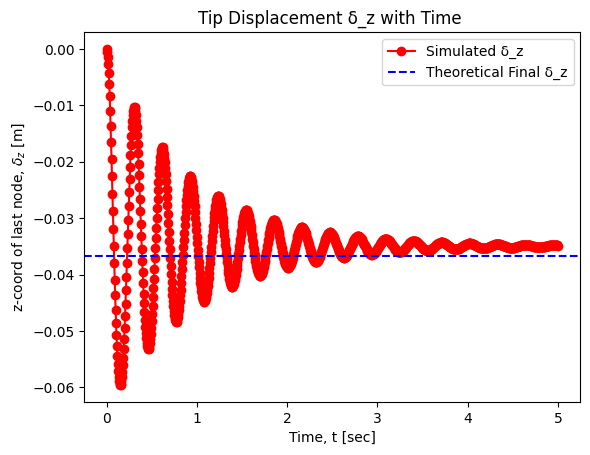

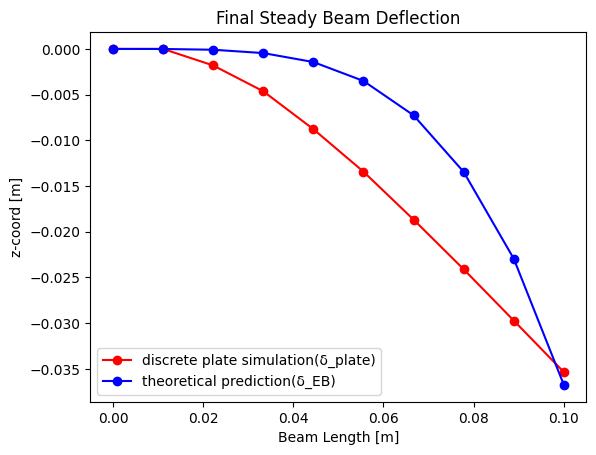

/tmp/ipython-input-717428403.py:31: RuntimeWarning: invalid value encountered in divide
  nd = (dEB - dPlate) / (dEB + dPlate)


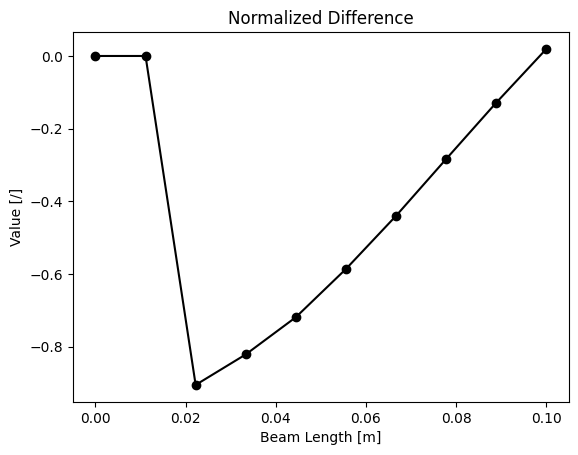

In [665]:
dPlatet = endZ -endZ[0]
dEBt = -q * l**4/(8*Y*I)

plt.figure(3)
time_array = np.arange(1, Nsteps+1) * dt
plt.plot(time_array, dPlatet, 'ro-', label = 'Simulated δ_z')
plt.box(True)
plt.xlabel('Time, t [sec]')
plt.ylabel('z-coord of last node, $\\delta_z$ [m]')
plt.title('Tip Displacement δ_z with Time ')
plt.axhline(y = dEBt, color='b', linestyle='--', label = 'Theoretical Final δ_z')
plt.legend()
plt.show()


lArray = np.linspace(0,l,10)
dEB = -q * lArray**4/(8*Y*I)
dPlate = qNew[2::3][:10]

plt.figure(4)
plt.plot(lArray, dPlate, 'ro-', label = 'discrete plate simulation(δ_plate)')
plt.plot(lArray, dEB, 'bo-', label = 'theoretical prediction(δ_EB)')
plt.box(True)
plt.xlabel('Beam Length [m]')
plt.ylabel('z-coord [m]')
plt.title('Final Steady Beam Deflection')
plt.legend()
plt.show()


nd = (dEB - dPlate) / (dEB + dPlate)
nd[0] = 0; nd[1] = 0

plt.figure(5)
plt.plot(lArray, nd, 'ko-', label = 'discrete plate simulation(δ_plate)')
plt.box(True)
plt.xlabel('Beam Length [m]')
plt.ylabel('Value [/]')
plt.title('Normalized Difference')
plt.show()
